In [217]:
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
%matplotlib inline

# Attempt with Soccer Ball

### Measurements

Error Propagation: $$c=2\pi r; dr=\frac{dc}{2\pi};A=\pi r^2; dA=2\pi rdr; V=\frac{4}{3}\pi r^3; dV=4\pi r^2dr$$

In [221]:
m=0.8398; dm=0.1*10**(-3)
circ=0.626; dcirc=0.001; r=circ/2/np.pi; dr=dcirc/2/np.pi
A=np.pi*(r)**2; dA=(r)*dcirc
V=4/3*np.pi*(r)**3; dV=4*np.pi*r**2*dr

We will use the following measurements to estimate the air density: 

Pressure: $989 \pm 5 \ (hPa)$

Temperature: $23 \pm 3 \ (^\circ C)$

Tool used: https://www.omnicalculator.com/physics/air-density

In [223]:
g=9.806
rho_air=1.17; drho_air=0.02

### Data Analysis

In [225]:
alldata=pd.read_excel("data/trial5.xlsx")
alldata

,Data Set 1:Time(s),Data Set 1:X-axis acceleration(m/s),Data Set 1:Y-axis acceleration(m/s),Data Set 1:Z-axis acceleration(m/s),Data Set 1:Altitude(m)
0,0.00,-1.552783,-9.292758,2.578076,26.996113
1,0.02,-1.773050,-9.235297,2.937206,NaN
2,0.04,-1.567149,-9.264028,3.507026,NaN
3,0.06,-1.423496,-9.129952,4.028963,NaN
4,0.08,-1.184076,-9.206567,3.085647,NaN
...,...,...,...,...,...
480,9.60,-0.671717,-4.863486,5.776730,20.377216
481,9.62,-1.773050,-4.274512,7.797436,NaN
482,9.64,-3.314916,-4.911370,8.276277,NaN
483,9.66,-4.258232,-8.177060,12.533167,NaN


In [226]:
namex="Data Set 1:X-axis acceleration(m/s)"; namey="Data Set 1:Y-axis acceleration(m/s)";namez="Data Set 1:Z-axis acceleration(m/s)";
namet="Data Set 1:Time(s)"

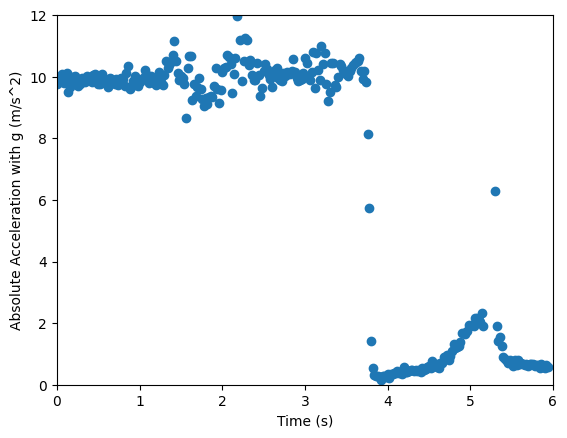

In [227]:
acc_abs_alldata=np.sqrt((alldata[namex])**2+(alldata[namey])**2+(alldata[namez])**2)
plt.plot(alldata[namet],acc_abs_alldata,"o")
plt.xlim([0,6])
plt.ylim([0,12]); plt.xlabel("Time (s)"); _=plt.ylabel("Absolute Acceleration with g (m/s^2)")
plt.show()

We will extract, from the data at rest, $a_{x,rest},a_{y,rest},a_{z,rest}$ and their corresponding uncertainties. Then we will calculate $$a=\sqrt{(a_x-a_{x,rest})^2+(a_y-a_{y,rest})^2+(a_z-a_{z,rest})^2},$$ which gives the absolute acceleration without $g$ (near $0$ when at rest). Since the accelerometer has degree of uncertainty much smaller than other errors, we will neglect the errors in $a_x, a_y, a_z$, and consider only the uncertainties in the directional accelerations at rest, given by their standard error.
$$da=\sqrt{\frac{((a_x-a_{x,rest})da_{x,rest})^2+((a_y-a_{y,rest})da_{y,rest})^2+((a_z-a_{z,rest})da_{z,rest})^2}{(a_x-a_{x,rest})^2+(a_y-a_{y,rest})^2+(a_z-a_{z,rest})^2}}.$$ Note that there is also minimal uncertainty in time. We estimate that the error in the choice of time for the starting point of the drop is about $0.1 s$ (I will not present this error for the upcoming graphs).

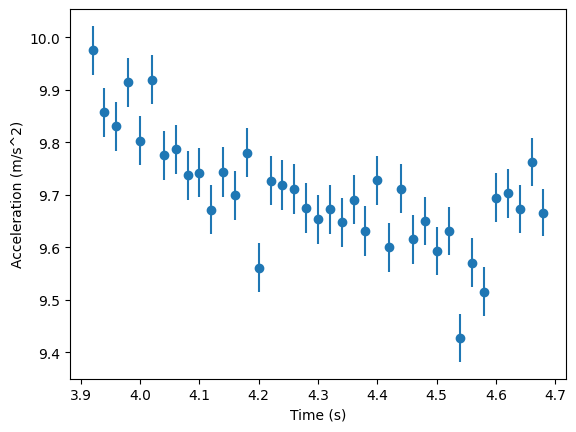

In [229]:
rest_cuts=(alldata[namet]>2.5)&(alldata[namet]<3.6)
mean_rest_xacc=alldata[namex][rest_cuts].mean()
mean_rest_yacc=alldata[namey][rest_cuts].mean()
mean_rest_zacc=alldata[namez][rest_cuts].mean()

mean_rest_xaccerr=alldata[namex][rest_cuts].std()/np.sqrt(len(alldata[namex][rest_cuts]))
mean_rest_yaccerr=alldata[namey][rest_cuts].std()/np.sqrt(len(alldata[namey][rest_cuts]))
mean_rest_zaccerr=alldata[namez][rest_cuts].std()/np.sqrt(len(alldata[namez][rest_cuts]))

t_0=3.9; t_1=4.7;
dt=0.1
drop_cuts=(alldata[namet]>t_0)&(alldata[namet]<t_1)
data=alldata[drop_cuts]; time=data[namet];
xacc_withg=data[namex]; yacc_withg=data[namey]; zacc_withg=data[namez]

xacc=[xacc_withg[i]-mean_rest_xacc for i in range(data.index[0],data.index[-1]+1)]
yacc=[yacc_withg[i]-mean_rest_yacc for i in range(data.index[0],data.index[-1]+1)]
zacc=[zacc_withg[i]-mean_rest_zacc for i in range(data.index[0],data.index[-1]+1)]

acc=[np.sqrt(xacc[i]**2+yacc[i]**2+zacc[i]**2) for i in range(len(xacc))]
dacc=[np.sqrt(((xacc[i]*mean_rest_xaccerr)**2+(yacc[i]*mean_rest_yaccerr)**2+(zacc[i]*mean_rest_zaccerr)**2))/(acc[i]) 
      for i in range(len(xacc))]

_=plt.errorbar(time,acc,yerr=dacc,fmt="o"); plt.xlabel("Time (s)"); _=plt.ylabel("Acceleration (m/s^2)")
plt.show()

We integrate for velocity: $$v(t)=\int_{t_0}^t a(t')dt'.$$ Error propagating, we get $$dv(t)=a(t)dt.$$

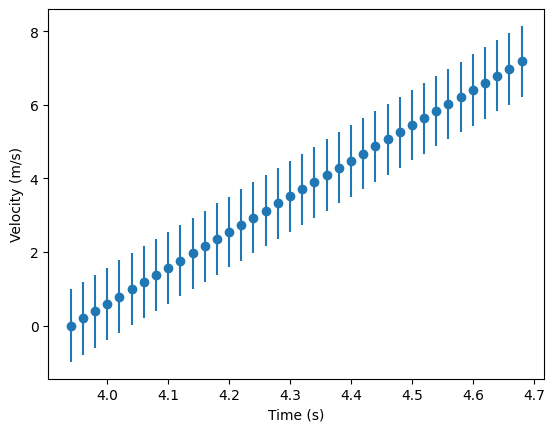

In [231]:
vel=[]
for i in range(1,len(time)):
    a=acc[:i]; t=time[:i] 
    vel.append(np.trapz(a,t)) 

dvel=[acc[i]*dt for i in range(1,len(time))]

_=plt.errorbar(time[1:],vel,yerr=dvel,fmt="o") 
_=plt.xlabel("Time (s)"); _=plt.ylabel("Velocity (m/s)");
plt.show()

By Newton's Second Law, $$ma=mg-F_D-F_B \implies F_D=m(g-a)-F_B=m(g-a)-\rho_{air}Vg.$$

Error propagating: $$dF_D=\sqrt{(mda)^2+(Vgd\rho_{air})^2+(\rho_{air}gdV)^2}.$$ The drag force will be graphed against the velocity squared, which has error $$d(v^2)=2vdv.$$

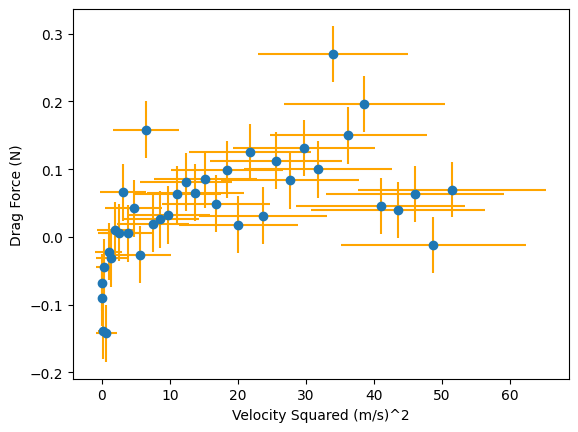

In [234]:
m=0.8398
g=9.806

Drag=[m*(g-acc[i])-rho_air*V*g for i in range(1,len(time))]
dDrag=[np.sqrt((m*dacc[i])**2+(V*g*drho_air)**2+(rho_air*g*dV)) for i in range(1,len(time))]

v_sq=[vel[i]**2 for i in range(len(vel))]
dv_sq=[2*vel[i]*dvel[i] for i in range(len(vel))]

plt.errorbar(v_sq,Drag,xerr=dv_sq,yerr=dDrag,fmt="o",ecolor="orange")
plt.xlabel("Velocity Squared (m/s)^2"); _=plt.ylabel("Drag Force (N)")
plt.show()

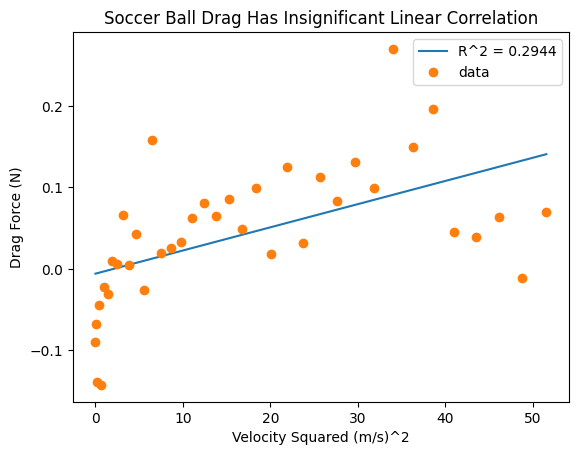

In [235]:
p,cov=curve_fit(lambda x,A,B:A*x+B,v_sq,Drag)
fitA=p[0]; fitB=p[1]
plt.plot(v_sq,[fitA*v_sq[i]+fitB for i in range(0,len(time)-1)],label = 'R^2 = 0.2944')
plt.plot(v_sq,Drag,"o",label='data')
plt.title("Soccer Ball Drag Has Insignificant Linear Correlation")
plt.xlabel("Velocity Squared (m/s)^2"); _=plt.ylabel("Drag Force (N)")
plt.legend()
plt.show()

In [236]:
def model(v_sq, a, b):
    return a * v_sq + b

Drag_pred = model(np.array(v_sq), *p)

# Calculate R^2
ss_res = np.sum((Drag - Drag_pred) ** 2)
ss_tot = np.sum((Drag - np.mean(Drag)) ** 2)
r_squared = 1 - (ss_res / ss_tot)

print(f"R^2 = {r_squared}")

R^2 = 0.2944372461545447


This value of $R^2$ is too low for the data to establish any significant result using the linear fit of the drag equation. Thus, we will no longer continue analyzing the drag force of the soccer ball, and switch instead to the beach ball. 

# Beachball

## Beachball-Initial Measurements

We made the following measurements on the beachball:

Mass ($m_b$): $0.1522 \pm 0.0001 \ (kg)$

Circumference: $1.234 \pm 0.002 \ (m)$

In [240]:
m_b=0.1522 #kg
dm_b=0.0001 #kg
circ_b=1.234 #m
dcirc_b=0.002 #m
r_b=circ_b/2/np.pi; dr_b=dcirc_b/2/np.pi

V_b=4/3*np.pi*(circ_b/(2*np.pi))**3
A_b=np.pi*(circ_b/(2*np.pi))**2

dA_b=(r_b)*dcirc_b
dV_b=4*np.pi*r_b**2*dr_b

## Beachball-Trial 1

In [242]:
alldata_b1=pd.read_excel("data/beach/trial1.xlsx")
alldata_b1

,Data Set 1:Time(s),Data Set 1:X-axis acceleration(m/s),Data Set 1:Y-axis acceleration(m/s),Data Set 1:Z-axis acceleration(m/s),Data Set 1:Altitude(m)
0,0.00,0.123158,0.169126,9.765470,26.996113
1,0.02,0.051332,0.111666,9.813354,NaN
2,0.04,0.070485,0.025474,9.961794,NaN
3,0.06,0.185407,0.207434,10.043197,NaN
4,0.08,0.300329,0.250529,10.138966,NaN
...,...,...,...,...,...
590,11.80,5.328152,8.055627,-0.285389,18.086365
591,11.82,5.174923,8.074780,-0.323696,NaN
592,11.84,5.280268,8.242374,-0.266236,NaN
593,11.86,5.280268,8.084357,-0.247082,NaN


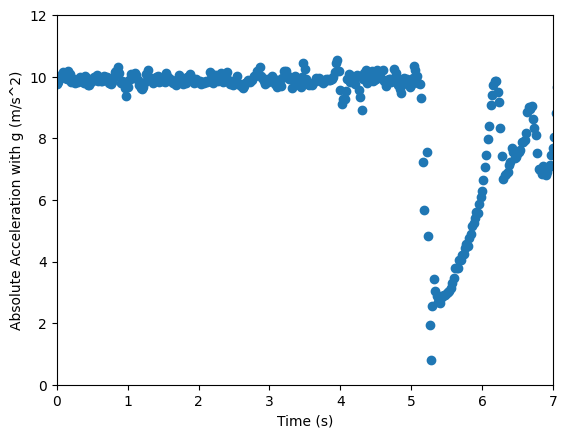

In [243]:
acc_abs_alldata_b1=np.sqrt((alldata_b1[namex])**2+(alldata_b1[namey])**2+(alldata_b1[namez])**2)
plt.plot(alldata_b1[namet],acc_abs_alldata_b1,"o")
plt.xlim([0,7])
plt.ylim([0,12])
plt.xlabel("Time (s)"); _=plt.ylabel("Absolute Acceleration with g (m/s^2)")
plt.show()

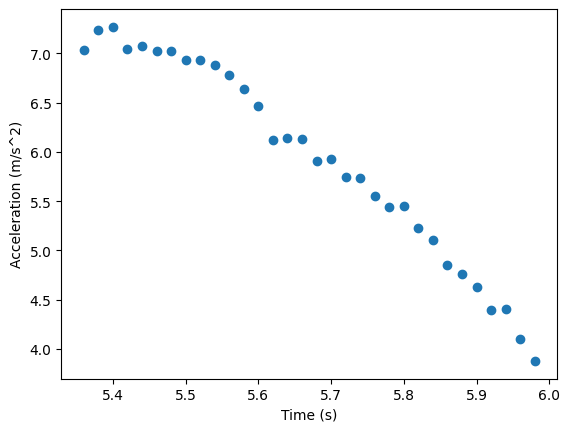

In [244]:
rest_cuts_b1=(alldata_b1[namet]>0.1)&(alldata[namet]<4)
mean_rest_xacc_b1=alldata_b1[namex][rest_cuts_b1].mean()
mean_rest_yacc_b1=alldata_b1[namey][rest_cuts_b1].mean()
mean_rest_zacc_b1=alldata_b1[namez][rest_cuts_b1].mean()

mean_rest_xaccerr_b1=alldata_b1[namex][rest_cuts_b1].std()/np.sqrt(len(alldata_b1[namex][rest_cuts_b1]))
mean_rest_yaccerr_b1=alldata_b1[namey][rest_cuts_b1].std()/np.sqrt(len(alldata_b1[namey][rest_cuts_b1]))
mean_rest_zaccerr_b1=alldata_b1[namez][rest_cuts_b1].std()/np.sqrt(len(alldata_b1[namez][rest_cuts_b1]))

t_0_b1=5.35; t_1_b1=6;

drop_cuts_b1=(alldata_b1[namet]>t_0_b1)&(alldata_b1[namet]<t_1_b1)
data_b1=alldata_b1[drop_cuts_b1]; time_b1=data_b1[namet];
xacc_withg_b1=data_b1[namex]; yacc_withg_b1=data_b1[namey]; zacc_withg_b1=data_b1[namez]
xacc_b1=[xacc_withg_b1[i]-mean_rest_xacc_b1 for i in range(data_b1.index[0],data_b1.index[-1]+1)]
yacc_b1=[yacc_withg_b1[i]-mean_rest_yacc_b1 for i in range(data_b1.index[0],data_b1.index[-1]+1)]
zacc_b1=[zacc_withg_b1[i]-mean_rest_zacc_b1 for i in range(data_b1.index[0],data_b1.index[-1]+1)]

acc_b1=[np.sqrt(xacc_b1[i]**2+yacc_b1[i]**2+zacc_b1[i]**2) for i in range(len(xacc_b1))]
dacc_b1=[np.sqrt(((xacc_b1[i]*mean_rest_xaccerr_b1)**2+(yacc_b1[i]*mean_rest_yaccerr_b1)**2
                  +(zacc_b1[i]*mean_rest_zaccerr_b1)**2))/(acc_b1[i]) for i in range(len(acc_b1))]

_=plt.errorbar(time_b1,acc_b1,yerr=dacc_b1,fmt="o",ecolor="r")
plt.xlabel("Time (s)"); _=plt.ylabel("Acceleration (m/s^2)")
plt.show()

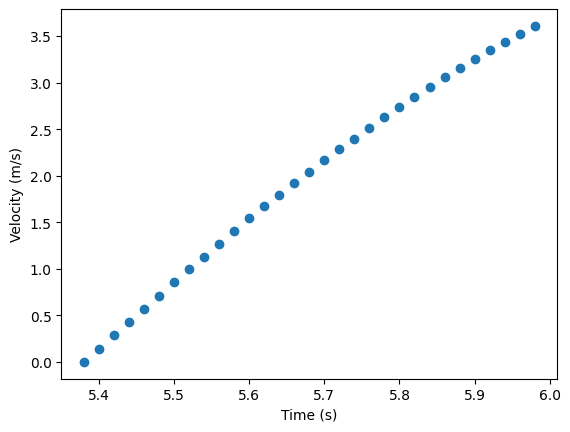

In [245]:
vel_b1=[]
for i in range(1,len(time_b1)):
    a=acc_b1[:i]; t=time_b1[:i] 
    vel_b1.append(np.trapz(a,t)) 

_=plt.errorbar(time_b1[1:],vel_b1,fmt="o") 
_=plt.xlabel("Time (s)"); _=plt.ylabel("Velocity (m/s)");
plt.show()

By Newton's Second Law, $$ma=mg-F_D-F_B \implies F_D=m(g-a)-F_B=m(g-a)-\rho_{air}V_{ball}g.$$ We will graph Drag Force vs. Velocity Squared to derive a linear relationship between the two variables. Since the $x$-uncertainty will not be accounted for in the ``curve_fit`` linear regression, we will not account for the error here. The error propagation has been done already earlier. 

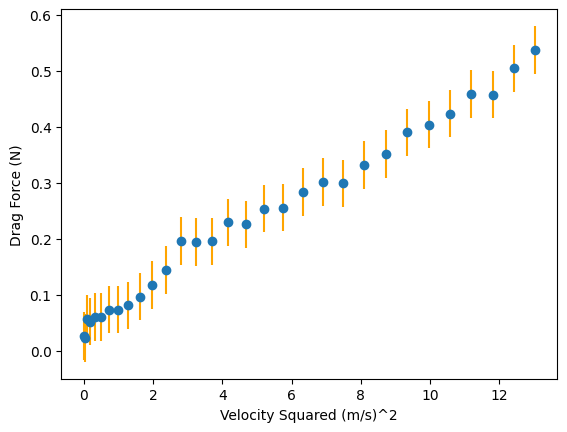

In [247]:
Drag_b1=[m_b*(g-acc_b1[i])-rho_air*V_b*g for i in range(1,len(time_b1))]
v_sq_b1=[vel_b1[i]**2 for i in range(0,len(time_b1)-1)]

dDrag_b1=[np.sqrt((m_b*dacc_b1[i])**2+(V_b*g*drho_air)**2+(rho_air*g*dV_b)) for i in range(1,len(time_b1))]

plt.errorbar(v_sq_b1,Drag_b1,yerr=dDrag_b1,fmt="o",ecolor="orange")
plt.xlabel("Velocity Squared (m/s)^2"); _=plt.ylabel("Drag Force (N)")
plt.show()

The drag equation tells us: $$F_D=\frac{1}{2}\rho_{air} v^2c_dA.$$

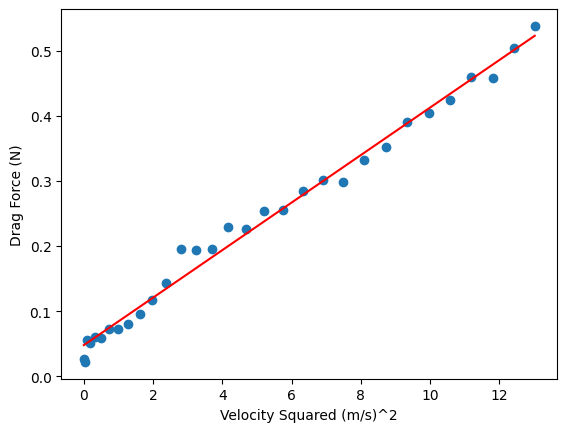

In [249]:
p_b1,cov_b1=curve_fit(lambda x,A,B:A*x+B,v_sq_b1,Drag_b1,sigma=dDrag_b1,absolute_sigma=True)
fitA_b1=p_b1[0]; fitdA_b1=cov_b1[0,0]
fitB_b1=p_b1[1]

plt.plot(v_sq_b1,Drag_b1,"o")
plt.plot(v_sq_b1,[fitA_b1*v_sq_b1[i]+fitB_b1 for i in range(0,len(time_b1)-1)],color="r")
plt.xlabel("Velocity Squared (m/s)^2"); _=plt.ylabel("Drag Force (N)")
plt.show()

We justify that a linear fit is appropriate in this case by calculating $R^2$:

In [251]:
Drag_pred_b1 = model(np.array(v_sq_b1), *p_b1)

# Calculate R^2
ss_res_b1 = np.sum((Drag_b1 - Drag_pred_b1) ** 2)
ss_tot_b1 = np.sum((Drag_b1 - np.mean(Drag_b1)) ** 2)
r_squared_b1 = 1 - (ss_res_b1 / ss_tot_b1)

print(f"R^2 = {r_squared_b1}")

R^2 = 0.9893944718670521


We have found the slope $k$ and: $$c_d=2\frac{k}{\rho_{air}A},$$ error propagating which we get 

$$dc_d=\sqrt{(2\frac{dk}{\rho_{air}A})^2+(2\frac{k}{\rho_{air}^2A}d\rho_{air})^2+(2\frac{k \ dA}{\rho_{air}A^2})^2}$$

In [254]:
coeff_b1=2*fitA_b1/A_b/rho_air
dcoeff_b1=np.sqrt((2*fitdA_b1/A_b/rho_air)**2+(2*fitA_b1/A_b/(rho_air**2)*drho_air)**2
                 +(2*fitA_b1*dA_b/rho_air/(A_b**2))**2)
print("The drag coefficient is %2.2f +/- %2.2f" % (coeff_b1,dcoeff_b1))

The drag coefficient is 0.51 +/- 0.01


# Beachball Trial 2

In [256]:
alldata_b2=pd.read_excel("data/beach/trial2.xlsx")
alldata_b2

,Data Set 1:Time(s),Data Set 1:X-axis acceleration(m/s),Data Set 1:Y-axis acceleration(m/s),Data Set 1:Z-axis acceleration(m/s),Data Set 1:Altitude(m)
0,0.00,0.357790,1.141172,9.731951,25.215219
1,0.02,0.353001,1.059769,9.846872,NaN
2,0.04,0.386520,1.093288,9.980947,NaN
3,0.06,0.410462,1.050193,9.832507,NaN
4,0.08,0.453558,1.074135,9.741528,NaN
...,...,...,...,...,...
640,12.80,8.081484,-8.066927,-30.509790,21.267662
641,12.82,8.282597,-9.019819,-28.120378,NaN
642,12.84,7.085496,-8.713362,-26.497108,NaN
643,12.86,5.744743,-6.467601,-26.564146,NaN


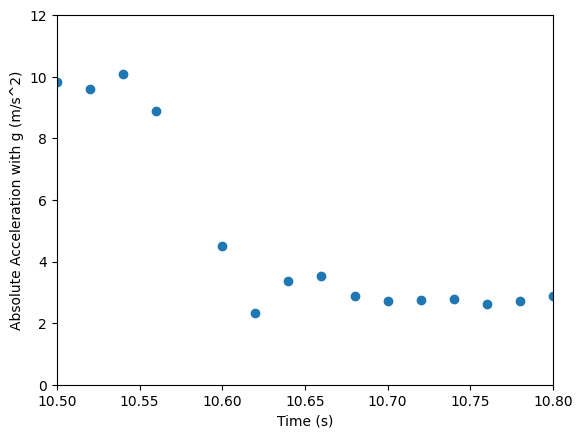

In [257]:
acc_abs_alldata_b2=np.sqrt((alldata_b2[namex])**2+(alldata_b2[namey])**2+(alldata_b2[namez])**2)
plt.plot(alldata_b2[namet],acc_abs_alldata_b2,"o")
plt.xlim([10.5,10.8])
plt.ylim([0,12])
plt.xlabel("Time (s)"); _=plt.ylabel("Absolute Acceleration with g (m/s^2)")
plt.show()

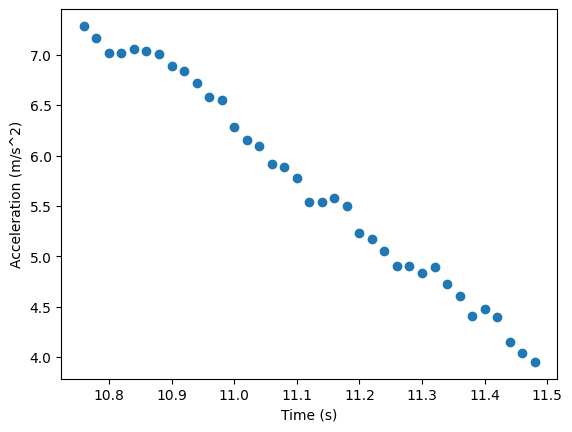

In [258]:
rest_cuts_b2=(alldata_b2[namet]>8.2)&(alldata[namet]<10)
mean_rest_xacc_b2=alldata_b2[namex][rest_cuts_b2].mean()
mean_rest_yacc_b2=alldata_b2[namey][rest_cuts_b2].mean()
mean_rest_zacc_b2=alldata_b2[namez][rest_cuts_b2].mean()

t_0_b2=10.75; t_1_b2=11.5;

drop_cuts_b2=(alldata_b2[namet]>t_0_b2)&(alldata_b2[namet]<t_1_b2)
data_b2=alldata_b2[drop_cuts_b2]; time_b2=data_b2[namet];
xacc_withg_b2=data_b2[namex]; yacc_withg_b2=data_b2[namey]; zacc_withg_b2=data_b2[namez]
xacc_b2=[xacc_withg_b2[i]-mean_rest_xacc_b2 for i in range(data_b2.index[0],data_b2.index[-1]+1)]
yacc_b2=[yacc_withg_b2[i]-mean_rest_yacc_b2 for i in range(data_b2.index[0],data_b2.index[-1]+1)]
zacc_b2=[zacc_withg_b2[i]-mean_rest_zacc_b2 for i in range(data_b2.index[0],data_b2.index[-1]+1)]

acc_b2=[np.sqrt(xacc_b2[i]**2+yacc_b2[i]**2+zacc_b2[i]**2) for i in range(len(xacc_b2))]

_=plt.plot(time_b2,acc_b2,"o"); plt.xlabel("Time (s)"); _=plt.ylabel("Acceleration (m/s^2)")
plt.show()

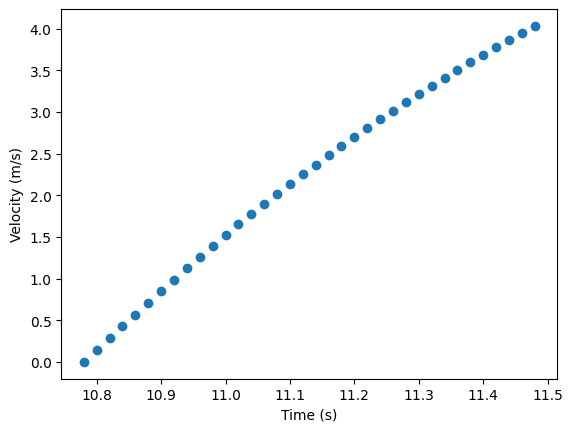

In [259]:
vel_b2=[]
for i in range(1,len(time_b2)):
    a=acc_b2[:i]; t=time_b2[:i] 
    vel_b2.append(np.trapz(a,t)) 
_=plt.plot(time_b2[1:],vel_b2,"o") 
_=plt.xlabel("Time (s)"); _=plt.ylabel("Velocity (m/s)");
plt.show()

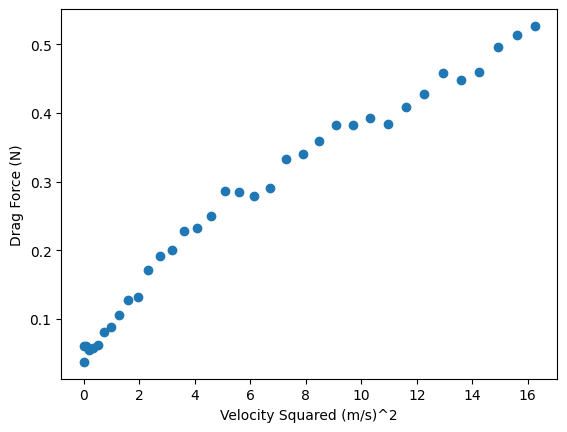

In [260]:
Drag_b2=[m_b*(g-acc_b2[i])-rho_air*V_b*g for i in range(1,len(time_b2))]
v_sq_b2=[vel_b2[i]**2 for i in range(0,len(time_b2)-1)]
plt.plot(v_sq_b2,Drag_b2,"o")
plt.xlabel("Velocity Squared (m/s)^2"); _=plt.ylabel("Drag Force (N)")
plt.show()

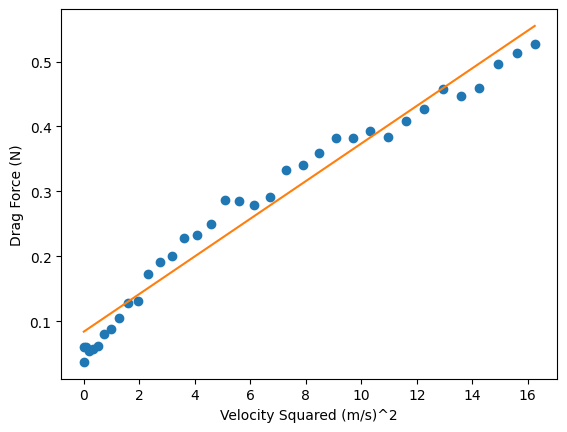

In [261]:
p_b2,cov_b2=curve_fit(lambda x,A,B:A*x+B,v_sq_b2,Drag_b2)
fitA_b2=p_b2[0]
fitB_b2=p_b2[1]

plt.plot(v_sq_b2,Drag_b2,"o")
plt.plot(v_sq_b2,[fitA_b2*v_sq_b2[i]+fitB_b2 for i in range(0,len(time_b2)-1)])
plt.xlabel("Velocity Squared (m/s)^2"); _=plt.ylabel("Drag Force (N)")
plt.show()

In [262]:
coeff_b2=2*fitA_b2/A_b/rho_air
print(coeff_b2)

0.4089076134323528


# Beachball Trial 3

In [264]:
alldata_b3=pd.read_excel("data/beach/trial3.xlsx")
alldata_b3

,Data Set 1:Time(s),Data Set 1:X-axis acceleration(m/s),Data Set 1:Y-axis acceleration(m/s),Data Set 1:Z-axis acceleration(m/s),Data Set 1:Altitude(m)
0,0.00,0.410462,1.160326,9.880391,24.578432
1,0.02,0.410462,1.169903,9.765470,NaN
2,0.04,0.491865,1.112442,9.794200,NaN
3,0.06,0.501442,1.011885,9.990524,NaN
4,0.08,0.606786,1.007097,9.942640,NaN
...,...,...,...,...,...
230,4.60,-5.531947,-2.158037,12.063903,21.777622
231,4.62,11.433367,4.651072,6.734410,NaN
232,4.64,-2.328505,-1.157261,-14.473429,NaN
233,4.66,1.511795,-1.564276,6.207686,NaN


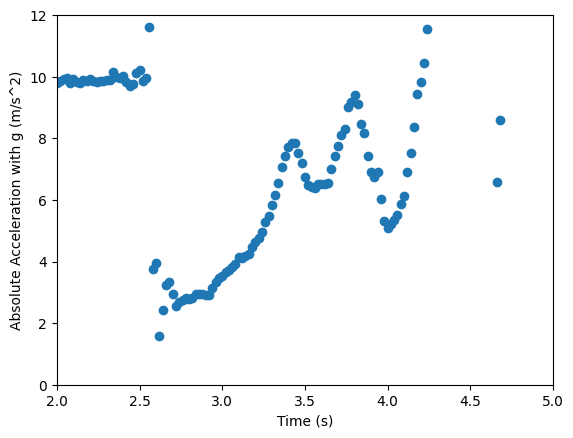

In [265]:
acc_abs_alldata_b3=np.sqrt((alldata_b3[namex])**2+(alldata_b3[namey])**2+(alldata_b3[namez])**2)
plt.plot(alldata_b3[namet],acc_abs_alldata_b3,"o")
plt.xlim([2,5])
plt.ylim([0,12])
plt.xlabel("Time (s)"); _=plt.ylabel("Absolute Acceleration with g (m/s^2)")
plt.show()

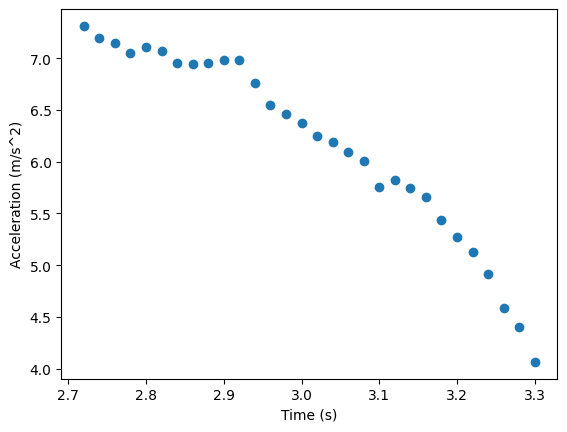

In [266]:
rest_cuts_b3=(alldata_b3[namet]>1.)&(alldata[namet]<2)
mean_rest_xacc_b3=alldata_b3[namex][rest_cuts_b3].mean()
mean_rest_yacc_b3=alldata_b3[namey][rest_cuts_b3].mean()
mean_rest_zacc_b3=alldata_b3[namez][rest_cuts_b3].mean()

t_0_b3=2.7; t_1_b3=3.3;

drop_cuts_b3=(alldata_b3[namet]>t_0_b3)&(alldata_b3[namet]<t_1_b3)
data_b3=alldata_b3[drop_cuts_b3]; time_b3=data_b3[namet];
xacc_withg_b3=data_b3[namex]; yacc_withg_b3=data_b3[namey]; zacc_withg_b3=data_b3[namez]
xacc_b3=[xacc_withg_b3[i]-mean_rest_xacc_b3 for i in range(data_b3.index[0],data_b3.index[-1]+1)]
yacc_b3=[yacc_withg_b3[i]-mean_rest_yacc_b3 for i in range(data_b3.index[0],data_b3.index[-1]+1)]
zacc_b3=[zacc_withg_b3[i]-mean_rest_zacc_b3 for i in range(data_b3.index[0],data_b3.index[-1]+1)]

acc_b3=[np.sqrt(xacc_b3[i]**2+yacc_b3[i]**2+zacc_b3[i]**2) for i in range(len(xacc_b3))]

_=plt.plot(time_b3,acc_b3,"o"); plt.xlabel("Time (s)"); _=plt.ylabel("Acceleration (m/s^2)")
plt.show()

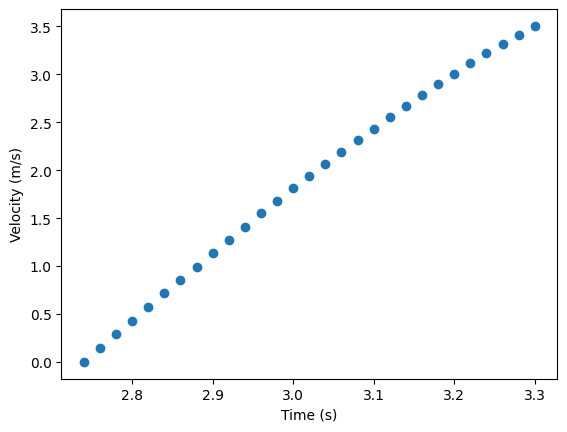

In [267]:
vel_b3=[]
for i in range(1,len(time_b3)):
    a=acc_b3[:i]; t=time_b3[:i] 
    vel_b3.append(np.trapz(a,t)) 
_=plt.plot(time_b3[1:],vel_b3,"o") 
_=plt.xlabel("Time (s)"); _=plt.ylabel("Velocity (m/s)");
plt.show()

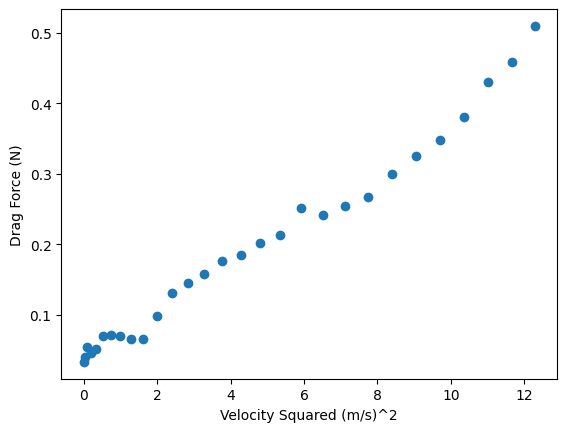

In [268]:
Drag_b3=[m_b*(g-acc_b3[i])-rho_air*V_b*g for i in range(1,len(time_b3))]
v_sq_b3=[vel_b3[i]**2 for i in range(0,len(time_b3)-1)]
plt.plot(v_sq_b3,Drag_b3,"o")
plt.xlabel("Velocity Squared (m/s)^2"); _=plt.ylabel("Drag Force (N)")
plt.show()

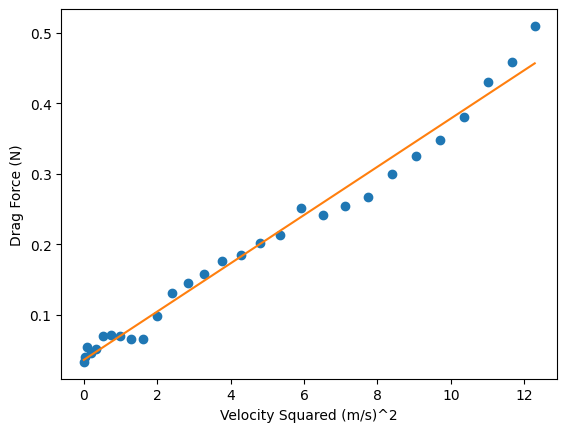

In [269]:
p_b3,cov_b3=curve_fit(lambda x,A,B:A*x+B,v_sq_b3,Drag_b3)
fitA_b3=p_b3[0]
fitB_b3=p_b3[1]

plt.plot(v_sq_b3,Drag_b3,"o")
plt.plot(v_sq_b3,[fitA_b3*v_sq_b3[i]+fitB_b3 for i in range(0,len(time_b3)-1)])
plt.xlabel("Velocity Squared (m/s)^2"); _=plt.ylabel("Drag Force (N)")
plt.show()

In [270]:
coeff_b3=2*fitA_b3/A_b/rho_air
print(coeff_b3)

0.4824914332137864


# Beachball Trial 4

In [272]:
alldata_b4=pd.read_excel("data/beach/trial4.xlsx")
alldata_b4

,Data Set 1:Time(s),Data Set 1:X-axis acceleration(m/s),Data Set 1:Y-axis acceleration(m/s),Data Set 1:Z-axis acceleration(m/s),Data Set 1:Altitude(m)
0,0.00,0.822265,1.174691,9.822930,24.832090
1,0.02,0.783957,1.050193,9.813354,NaN
2,0.04,0.898879,1.002309,9.722374,NaN
3,0.06,0.779169,1.016674,9.669702,NaN
4,0.08,0.683401,1.098077,9.674490,NaN
...,...,...,...,...,...
190,3.80,-1.868818,-5.366268,-17.921080,22.411768
191,3.82,-5.761790,-15.182494,-19.534771,NaN
192,3.84,-122.392929,-3.781306,-157.067291,NaN
193,3.86,31.017937,-40.896221,99.768303,NaN


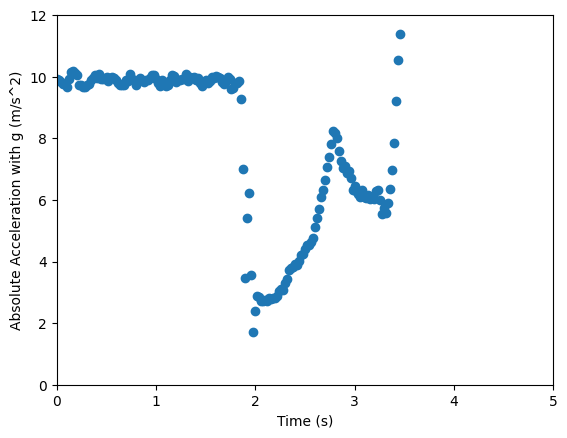

In [273]:
acc_abs_alldata_b4=np.sqrt((alldata_b4[namex])**2+(alldata_b4[namey])**2+(alldata_b4[namez])**2)
plt.plot(alldata_b4[namet],acc_abs_alldata_b4,"o")
plt.xlim([0,5])
plt.ylim([0,12])
plt.xlabel("Time (s)"); _=plt.ylabel("Absolute Acceleration with g (m/s^2)")
plt.show()

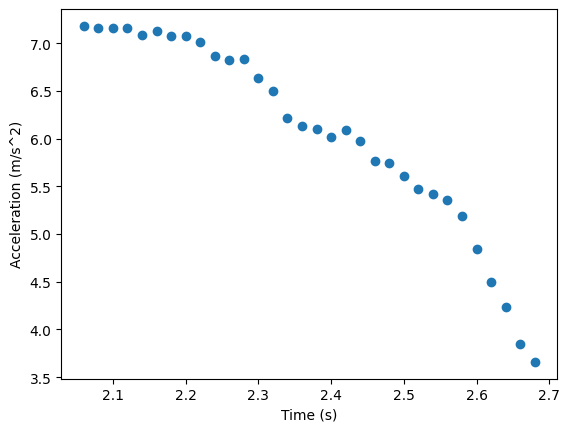

In [274]:
rest_cuts_b4=(alldata_b4[namet]>0.5)&(alldata[namet]<1.8)
mean_rest_xacc_b4=alldata_b4[namex][rest_cuts_b4].mean()
mean_rest_yacc_b4=alldata_b4[namey][rest_cuts_b4].mean()
mean_rest_zacc_b4=alldata_b4[namez][rest_cuts_b4].mean()

t_0_b4=2.05; t_1_b4=2.7;

drop_cuts_b4=(alldata_b4[namet]>t_0_b4)&(alldata_b4[namet]<t_1_b4)
data_b4=alldata_b4[drop_cuts_b4]; time_b4=data_b4[namet];
xacc_withg_b4=data_b4[namex]; yacc_withg_b4=data_b4[namey]; zacc_withg_b4=data_b4[namez]
xacc_b4=[xacc_withg_b4[i]-mean_rest_xacc_b4 for i in range(data_b4.index[0],data_b4.index[-1]+1)]
yacc_b4=[yacc_withg_b4[i]-mean_rest_yacc_b4 for i in range(data_b4.index[0],data_b4.index[-1]+1)]
zacc_b4=[zacc_withg_b4[i]-mean_rest_zacc_b4 for i in range(data_b4.index[0],data_b4.index[-1]+1)]

acc_b4=[np.sqrt(xacc_b4[i]**2+yacc_b4[i]**2+zacc_b4[i]**2) for i in range(len(xacc_b4))]

_=plt.plot(time_b4,acc_b4,"o"); plt.xlabel("Time (s)"); _=plt.ylabel("Acceleration (m/s^2)")
plt.show()

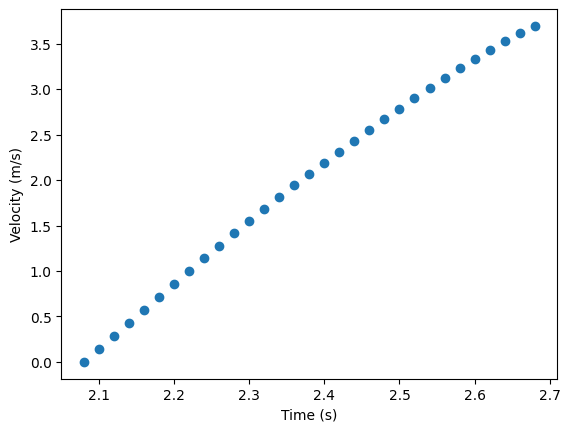

In [275]:
vel_b4=[]
for i in range(1,len(time_b4)):
    a=acc_b4[:i]; t=time_b4[:i] 
    vel_b4.append(np.trapz(a,t)) 
_=plt.plot(time_b4[1:],vel_b4,"o") 
_=plt.xlabel("Time (s)"); _=plt.ylabel("Velocity (m/s)");
plt.show()

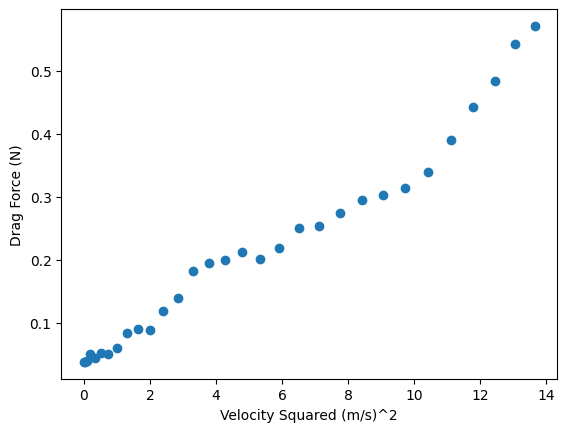

In [276]:
Drag_b4=[m_b*(g-acc_b4[i])-rho_air*V_b*g for i in range(1,len(time_b4))]
v_sq_b4=[vel_b4[i]**2 for i in range(0,len(time_b4)-1)]
plt.plot(v_sq_b4,Drag_b4,"o")
plt.xlabel("Velocity Squared (m/s)^2"); _=plt.ylabel("Drag Force (N)")
plt.show()

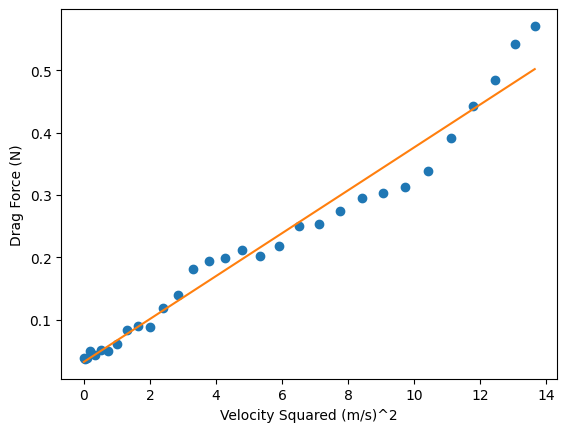

In [277]:
p_b4,cov_b4=curve_fit(lambda x,A,B:A*x+B,v_sq_b4,Drag_b4)
fitA_b4=p_b4[0]
fitB_b4=p_b4[1]

plt.plot(v_sq_b4,Drag_b4,"o")
plt.plot(v_sq_b4,[fitA_b4*v_sq_b4[i]+fitB_b4 for i in range(0,len(time_b4)-1)])
plt.xlabel("Velocity Squared (m/s)^2"); _=plt.ylabel("Drag Force (N)")
plt.show()

In [278]:
coeff_b4=2*fitA_b4/A_b/rho_air
print(coeff_b4)

0.48547762413116136


# Beachball Trial 5

In [280]:
alldata_b5=pd.read_excel("data/beach/trial5.xlsx")
alldata_b5

,Data Set 1:Time(s),Data Set 1:X-axis acceleration(m/s),Data Set 1:Y-axis acceleration(m/s),Data Set 1:Z-axis acceleration(m/s),Data Set 1:Altitude(m)
0,0.00,0.448769,0.288836,9.880391,24.83209
1,0.02,0.443981,0.149973,9.846872,NaN
2,0.04,0.338636,0.087724,9.851661,NaN
3,0.06,0.367366,0.341509,10.004889,NaN
4,0.08,0.266810,0.408547,10.158119,NaN
...,...,...,...,...,...
185,3.70,2.014577,10.378003,-26.932854,21.52132
186,3.72,-1.102674,6.915987,-20.214724,NaN
187,3.74,7.765450,-8.325500,-39.895065,NaN
188,3.76,6.855653,-4.006361,-21.263384,NaN


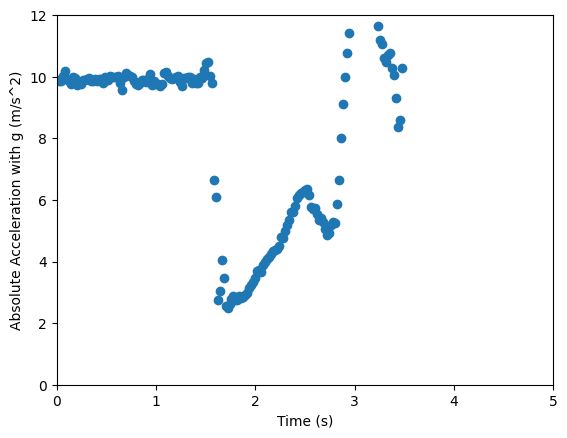

In [281]:
acc_abs_alldata_b5=np.sqrt((alldata_b5[namex])**2+(alldata_b5[namey])**2+(alldata_b5[namez])**2)
plt.plot(alldata_b5[namet],acc_abs_alldata_b5,"o")
plt.xlim([0,5])
plt.ylim([0,12])
plt.xlabel("Time (s)"); _=plt.ylabel("Absolute Acceleration with g (m/s^2)")
plt.show()

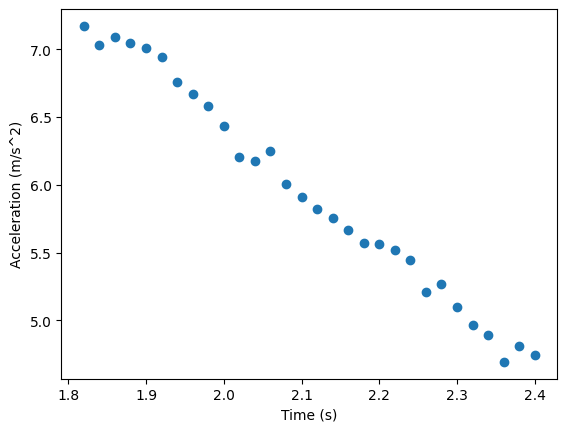

In [282]:
rest_cuts_b5=(alldata_b5[namet]>0.2)&(alldata[namet]<1.5)
mean_rest_xacc_b5=alldata_b5[namex][rest_cuts_b5].mean()
mean_rest_yacc_b5=alldata_b5[namey][rest_cuts_b5].mean()
mean_rest_zacc_b5=alldata_b5[namez][rest_cuts_b5].mean()

t_0_b5=1.8; t_1_b5=2.4;

drop_cuts_b5=(alldata_b5[namet]>t_0_b5)&(alldata_b5[namet]<t_1_b5)
data_b5=alldata_b5[drop_cuts_b5]; time_b5=data_b5[namet];
xacc_withg_b5=data_b5[namex]; yacc_withg_b5=data_b5[namey]; zacc_withg_b5=data_b5[namez]
xacc_b5=[xacc_withg_b5[i]-mean_rest_xacc_b5 for i in range(data_b5.index[0],data_b5.index[-1]+1)]
yacc_b5=[yacc_withg_b5[i]-mean_rest_yacc_b5 for i in range(data_b5.index[0],data_b5.index[-1]+1)]
zacc_b5=[zacc_withg_b5[i]-mean_rest_zacc_b5 for i in range(data_b5.index[0],data_b5.index[-1]+1)]

acc_b5=[np.sqrt(xacc_b5[i]**2+yacc_b5[i]**2+zacc_b5[i]**2) for i in range(len(xacc_b5))]

_=plt.plot(time_b5,acc_b5,"o"); plt.xlabel("Time (s)"); _=plt.ylabel("Acceleration (m/s^2)")
plt.show()

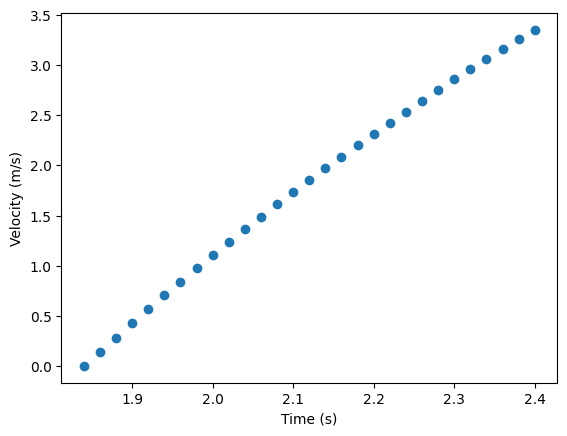

In [283]:
vel_b5=[]
for i in range(1,len(time_b5)):
    a=acc_b5[:i]; t=time_b5[:i] 
    vel_b5.append(np.trapz(a,t)) 
_=plt.plot(time_b5[1:],vel_b5,"o") 
_=plt.xlabel("Time (s)"); _=plt.ylabel("Velocity (m/s)");
plt.show()

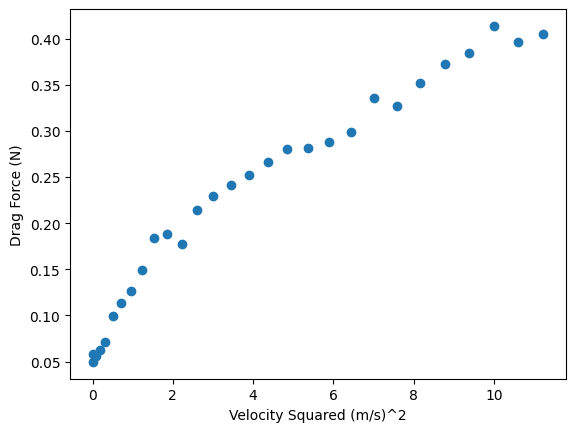

In [284]:
Drag_b5=[m_b*(g-acc_b5[i])-rho_air*V_b*g for i in range(1,len(time_b5))]
v_sq_b5=[vel_b5[i]**2 for i in range(0,len(time_b5)-1)]
plt.plot(v_sq_b5,Drag_b5,"o")
plt.xlabel("Velocity Squared (m/s)^2"); _=plt.ylabel("Drag Force (N)")
plt.show()

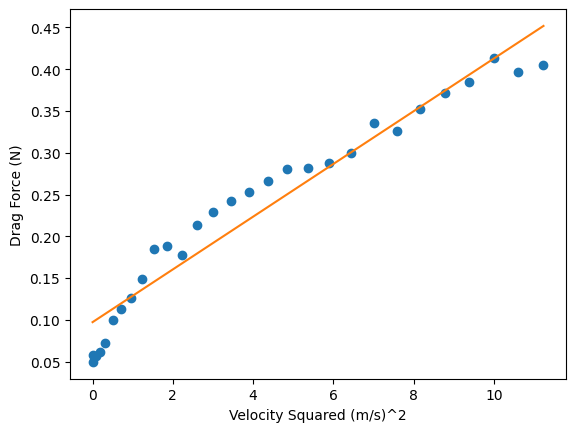

In [285]:
p_b5,cov_b5=curve_fit(lambda x,A,B:A*x+B,v_sq_b5,Drag_b5)
fitA_b5=p_b5[0]
fitB_b5=p_b5[1]

plt.plot(v_sq_b5,Drag_b5,"o")
plt.plot(v_sq_b5,[fitA_b5*v_sq_b5[i]+fitB_b5 for i in range(0,len(time_b5)-1)])
plt.xlabel("Velocity Squared (m/s)^2"); _=plt.ylabel("Drag Force (N)")
plt.show()

In [286]:
coeff_b5=2*fitA_b5/A_b/rho_air
print(coeff_b5)

0.44530487912714367


# Final Data

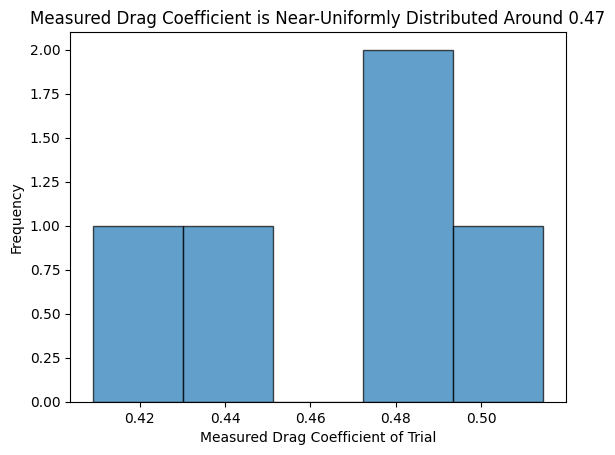

In [288]:
coeff_list = [globals()[f"coeff_b{i}"] for i in range(1, 6)]
plt.hist(coeff_list, bins=5, edgecolor='black', alpha=0.7)
plt.xlabel("Measured Drag Coefficient of Trial")
_=plt.ylabel("Frequency")
plt.title("Measured Drag Coefficient is Near-Uniformly Distributed Around 0.47")
plt.show()

As the histogram demonstrates, although the number of samples is very limited, we see an approximately normal distribution. We use the mean of these sample to estimate the true value of the drag coefficient. The uncertainty is given by the standard error, and since we do not know the population's standard deviation, we will use the sample's standard deviation to estimate the standard error:
$$\sigma_{\bar x}\approx \frac{\sigma_{x}}{\sqrt n}.$$

In [290]:
c_d_mean=np.array(coeff_list).mean()
c_d_err=np.array(coeff_list).std()/np.sqrt(len(coeff_list))
print("The estimated drag coefficient of the beach ball is %2.2f +/- %2.2f" % (c_d_mean,c_d_err))

The estimated drag coefficient of the beach ball is 0.47 +/- 0.02
